In [1]:
import numpy as np

In [2]:
data = np.load('data.npz')
x1= data['x1']
x2= data['x2']
y= data['y']
#test data
x1_test=data['x1_test']
x2_test=data['x2_test']
y_test=data['y_test']


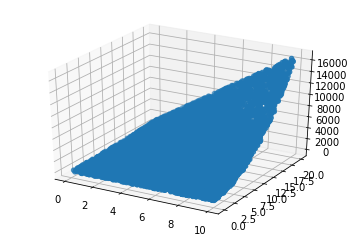

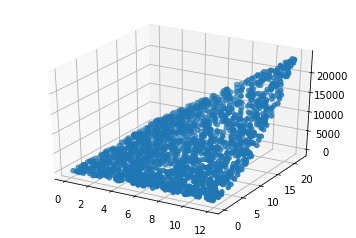

In [23]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
fig = plt.figure()
fig2 = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x1, x2, y)
ax2 = fig2.add_subplot(111,projection='3d')
ax2.scatter(x1_test, x2_test, y_test)


In [4]:
from sklearn import linear_model
model = linear_model.LinearRegression()
model.fit(np.column_stack((x1,x2)),y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [5]:
y_pred=model.predict(np.column_stack((x1_test,x2_test)))


In [6]:
y_pred


array([10412.55408876,  4740.93036483,  6143.89400245, ...,
        3650.21394141,  5741.08258713,  7296.39142551])

In [7]:
np.linalg.norm(y_test-y_pred)

113775.04100536309

### Direct method:

(The codes could be compacter than this, but I prefer more readable codes in assignments...)

In [8]:
def create_model_direct(degree):
    bias=np.ones(len(x1))
    X=bias
    powers=[]
    for i in range(degree+1):
        for j in range(degree+1):
            if i==0 and j==0 :
                continue
            if i+j>degree:
                continue
            bx1=np.power(x1,i)
            bx2=np.power(x2,j)
            powers.append([i,j])
            X=np.column_stack((X,np.multiply(bx1,bx2)))
    rX=np.matmul(X.T,X)
    inv_rX=np.linalg.inv(rX)
    return np.matmul(inv_rX,np.matmul(X.T,y)),powers

def prepare_data(x1,x2,powers):
    bias=np.ones(len(x1))
    data=bias
    for power in powers:
        bx1=np.power(x1,power[0])
        bx2=np.power(x2,power[1])
        data=np.column_stack((data,np.multiply(bx1,bx2)))
    return data
        

In [9]:
w_linear,linear_powers=create_model_direct(1)
w_mul_3,mul3_powers=create_model_direct(3)
w_mul_5,mul5_powers=create_model_direct(5)

In [10]:
ypred_linear_train= np.matmul(prepare_data(x1,x2,linear_powers),w_linear)
ypred_mul_3_train= np.matmul(prepare_data(x1,x2,mul3_powers),w_mul_3)
ypred_mul_5_train= np.matmul(prepare_data(x1,x2,mul5_powers),w_mul_5)

ypred_linear_test= np.matmul(prepare_data(x1_test,x2_test,linear_powers),w_linear)
ypred_mul_3_test= np.matmul(prepare_data(x1_test,x2_test,mul3_powers),w_mul_3)
ypred_mul_5_test= np.matmul(prepare_data(x1_test,x2_test,mul5_powers),w_mul_5)


In [11]:
print("Linear model:\n\nTrain SSE: %d\nTest SSE: %d"%(np.linalg.norm(y-ypred_linear_train)**2,np.linalg.norm(y_test-ypred_linear_test)**2))

print("\n\n\nModel with degree of 3:\n\nTrain SSE: %d\nTest SSE: %d"%(np.linalg.norm(y-ypred_mul_3_train)**2,np.linalg.norm(y_test-ypred_mul_3_test)**2))

print("\n\n\nModel with degree of 5:\n\nTrain SSE: %d\nTest SSE: %d"%(np.linalg.norm(y-ypred_mul_5_train)**2,np.linalg.norm(y_test-ypred_mul_5_test)**2))

Linear model:

Train SSE: 18317759690
Test SSE: 12944759955



Model with degree of 3:

Train SSE: 0
Test SSE: 0



Model with degree of 5:

Train SSE: 0
Test SSE: 0


The provided dataset(both train and test data) was generated with a multinomial function with a degree of 3.
so perfect matching of a regression model in degrees of 3 or more was expected. The 0 SSE of the models with the degree of 3 and 5 shows the models work perfectly and fit exactly on training and testing data which means the model successfully predicts all test inputs.


-----------------------------------

## Gradient Descent

The stop condition in this implementation of gradient descent learning for the regression model is if the number of iterations with no improvement in the SSE error is more than a constant K (for example 25) or not.

Also, there is a trick applied to avoid swinging around the optimum point; more precisely if the number of iteration with no more improvements, we probably swinging around the optimum point, so by dividing the learning rate and making it smaller, we have the change to reach the optimum spot.

For more improvement, gradient descent with momentum which one of the famous leaning methods in optimization and especially training deep neural networks are implemented.

In [12]:
stop_condition=25
improvement_treshold=0.01
bias=np.ones(len(x1))

def gradient(X,y,w):
    y_p=np.matmul(X,w)
    return np.matmul((-2*X.T),y-y_p)

def gradient_descend(X,y,w0,learning_rate):
    no_improvement=0
    w=w0
    pred= np.matmul(X,w)
    best=np.linalg.norm(y-pred)
    while no_improvement<stop_condition:
        grad=gradient(X,y,w)
        grad=grad/np.linalg.norm(grad)
        w=w-learning_rate*grad
        pred= np.matmul(X,w)
        current=np.linalg.norm(y-pred)
        if(best-current>0.01):
            best=current
            no_improvement=0
        else:
            no_improvement+=1
        if(no_improvement>10):
            learning_rate/=8
    return w

def gradient_descend_with_momentum(X,y,w0,learning_rate,decay_rate):
    no_improvement=0
    w=w0
    v=0
    pred= np.matmul(X,w)
    best=np.linalg.norm(y-pred)
    while no_improvement<stop_condition:
        grad=gradient(X,y,w)
        grad=grad/np.linalg.norm(grad)
        v=v*decay_rate+learning_rate*grad
        w=w-v
        pred= np.matmul(X,w)
        current=np.linalg.norm(y-pred)
        if(best-current>0.01):
            best=current
            no_improvement=0
        else:
            no_improvement+=1
        if(no_improvement>10):
            learning_rate/=8
    return w

In [13]:
# initiating w for each model
gdw_linear=np.random.rand(3)
gdw_mul3=np.random.rand(1+len(mul3_powers))
gdw_mul5=np.random.rand(1+len(mul5_powers))

# creating training data matrix for each model
X_linear=prepare_data(x1,x2,linear_powers)
X_mul3=prepare_data(x1,x2,mul3_powers)
X_mul5=prepare_data(x1,x2,mul5_powers)
    

In [34]:
# linear model training with GD
gdw_linear=gradient_descend(X_linear,y,gdw_linear,0.1)
# multunomial model with degree of 3 training with GD
gdw_mul3=gradient_descend(X_mul3,y,gdw_mul3,0.0005)
# multunomial model with degree of 5 training with GD
gdw_mul5=gradient_descend(X_mul5,y,gdw_mul5,0.0002)


y_linear_train = np.matmul(X_linear,gdw_linear)
y_linear_test = np.matmul(prepare_data(x1_test,x2_test,linear_powers),gdw_linear)

y_mul3_train = np.matmul(X_mul3,gdw_mul3)
y_mul3_test = np.matmul(prepare_data(x1_test,x2_test,mul3_powers),gdw_mul3)

y_mul5_train = np.matmul(X_mul5,gdw_mul5)
y_mul5_test = np.matmul(prepare_data(x1_test,x2_test,mul5_powers),gdw_mul5)


print("Linear model:\n\nTrain SSE: %d\nTest SSE: %d"%(np.linalg.norm(y-y_linear_train)**2,np.linalg.norm(y_test-y_linear_test)**2))

print("\n\n\nModel with degree of 3:\n\nTrain SSE: %d\nTest SSE: %d"%(np.linalg.norm(y-y_mul3_train)**2,np.linalg.norm(y_test-y_mul3_test)**2))

print("\n\n\nModel with degree of 5:\n\nTrain SSE: %d\nTest SSE: %d"%(np.linalg.norm(y-y_mul5_train)**2,np.linalg.norm(y_test-y_mul5_test)**2))


Linear model:

Train SSE: 18317807238
Test SSE: 12957142771



Model with degree of 3:

Train SSE: 27373
Test SSE: 46803



Model with degree of 5:

Train SSE: 127469161
Test SSE: 847653928


in a degree of 5 regression model, we have a complicated model with a high number of parameters which leads the model to overfit on training data and cause bigger SSE error than the model with a degree of 3.

# Apply generalization

There is a model in the sklearn library that exactly does what wanted in the assignment! so with no furture ado we are going to use it!

In [21]:
from sklearn import linear_model
alpha_values=[10**num for num in range(-4,4)] #[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
regresser = linear_model.RidgeCV(alphas=alpha_values, cv=5)
regresser

RidgeCV(alphas=[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000], cv=5,
    fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
    store_cv_values=False)

In [25]:
regresser.fit(np.column_stack((x1,x2)),y)

RidgeCV(alphas=[0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000], cv=5,
    fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
    store_cv_values=False)

In [32]:
print("Best alpha: ",regresser.alpha_) # The best value for alpha result of a 5 fold cross validation

Best alpha:  10


In [31]:
y_pred=model.predict(np.column_stack((x1_test,x2_test)))
print("SSE Error:",np.linalg.norm(y_test-y_pred))

SSE Error: 113775.04100536309


The results were the same. the provided data has a simple structure and this result was expected...